# Initialization

In [1]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

using project root as working dir


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


# Run

In [4]:
from src.graph import gen_graph
from dataclasses import asdict
from src.args import gridsearch_args, Args
from datetime import datetime
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob

from src.evaluator import Evaluator

In [7]:
experiment = dict(
    key=datetime.now().strftime("%d-%m--%H-%M"),
    reps=3,
    skip_to=0,
    args=gridsearch_args(),
)
df_result = pd.DataFrame({})

run_len = len(experiment['args']) * experiment['reps']
for i, args in enumerate(experiment["args"]):
    # override args for specific test
    args.note = "no epoch subsampling"

    # skip to beginning of specified repetition block
    if i < int(experiment['skip_to'] / experiment['reps']):
        print(f"skipping {i * experiment['reps']} to {(i + 1) * experiment['reps'] - 1}")
        continue

    # run with repetitions
    for rep in range(experiment["reps"]):
        run_index = i * experiment['reps'] + rep
        print(f"running evaluator {run_index}/{run_len}")

        graph, dim = gen_graph(args)
        evaluator = Evaluator(
            graph=graph,
            dim=dim,
            args=args,
            writer_log_dir=f"runs/{experiment['key']}/s{args.graph_size}--all-train--{rep}",
            device=device
        )
        start_time = time.time()
        evaluator.train(
            optimizer=torch.optim.Adam(evaluator.net.parameters(), lr=1e-3),
            save_fig=False
        )
        end_time = time.time()
        test_loss, test_ap, test_f1 = evaluator.test(
            epoch=args.epochs,
            save_fig=True
        )

        df_result = pd.concat([
            df_result,
            pd.Series({
                # run meta
                "run_index": run_index,
                "run_time": end_time - start_time,
                # run results
                "loss": test_loss,
                "ap": test_ap,
                "f1": test_f1,
                # run args
                **asdict(args),
            }).to_frame().T
        ], ignore_index=True)

    # save results just in case the run fails mid run
    df_result.to_csv(f"{experiment['key']}.csv.zip", index=False, compression=dict(method='zip', archive_name=f"{experiment['key']}.csv"))

running evaluator 0/9


building evaluator:   0%|          | 0/10 [00:00<?, ?it/s]

training model...: 0it [00:00, ?it/s]

testing model:   0%|          | 0/5 [00:00<?, ?it/s]

running evaluator 1/9


building evaluator:   0%|          | 0/10 [00:00<?, ?it/s]

training model...: 0it [00:00, ?it/s]

testing model:   0%|          | 0/5 [00:00<?, ?it/s]

running evaluator 2/9


building evaluator:   0%|          | 0/10 [00:00<?, ?it/s]

training model...: 0it [00:00, ?it/s]

# Results

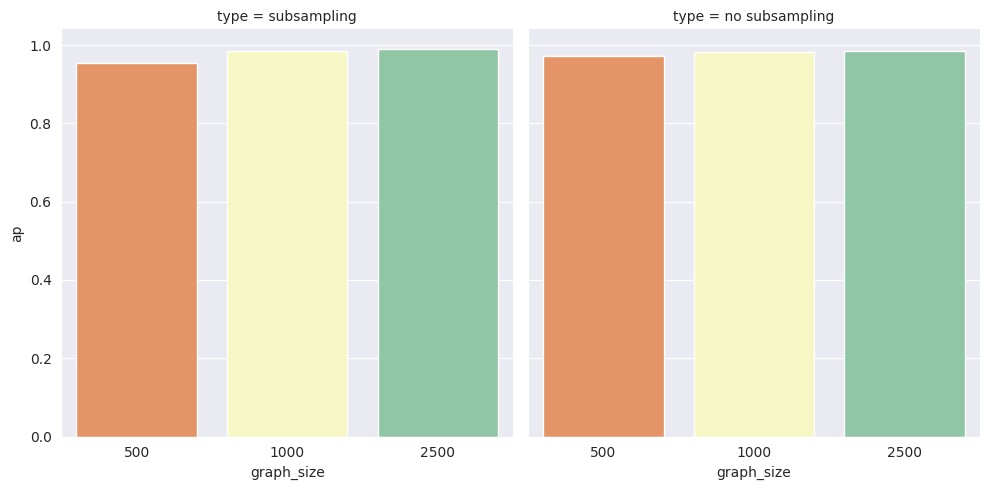

In [34]:
# mean score (bars)
df_result_mean_ap = df_result.groupby(["graph_size", "type"], as_index=False)["ap"].mean().sort_values(by=['ap'])
# print(df_result_mean_ap)

sns.catplot(
    data=df_result_mean_ap,
    col="type",
    x="graph_size",
    y="ap",
    palette="Spectral",
    kind = "bar"
)

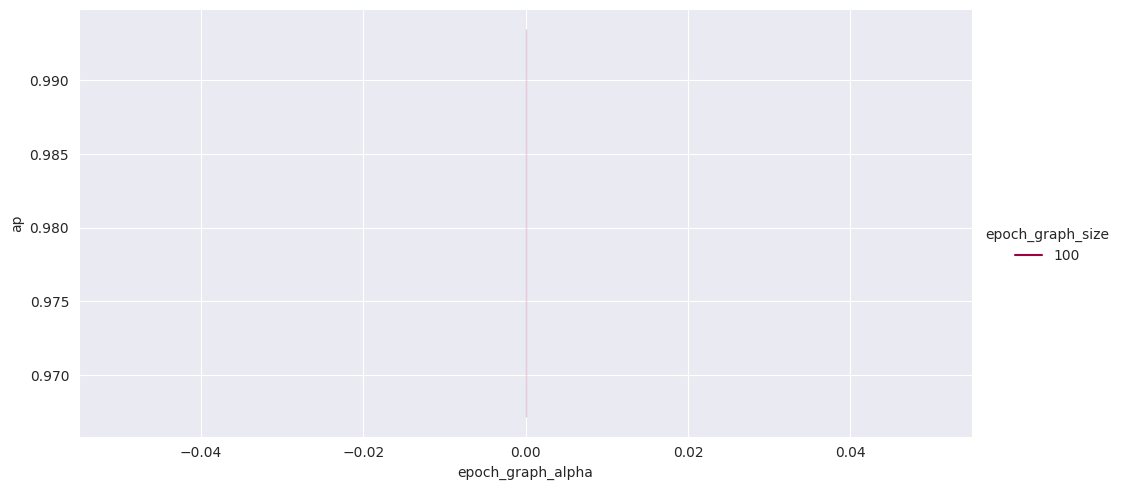

In [57]:
# score per epoch graph size and alpha (line with std)
sns.relplot(
    data=df_result, kind="line",
    hue="epoch_graph_size",
    x="epoch_graph_alpha",
    y="ap",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)

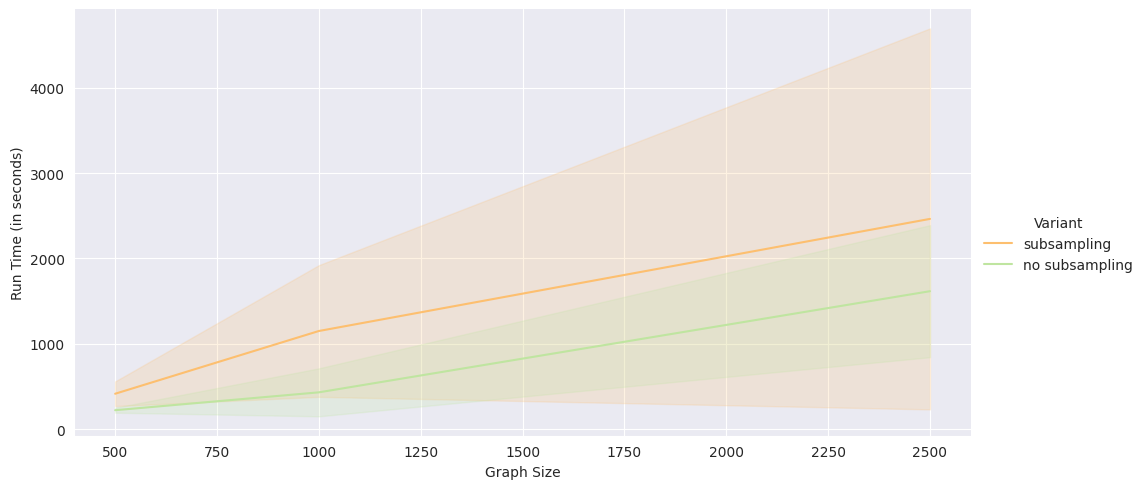

In [35]:
# run time per graph and epoch graph size (line with std)
g = sns.relplot(
    data=df_result, kind="line",
    hue="type",
    x="graph_size",
    y="run_time",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)
g.set_axis_labels("Graph Size", "Run Time (in seconds)")
g._legend.set_title("Variant")
plt.savefig('run_time.pdf')

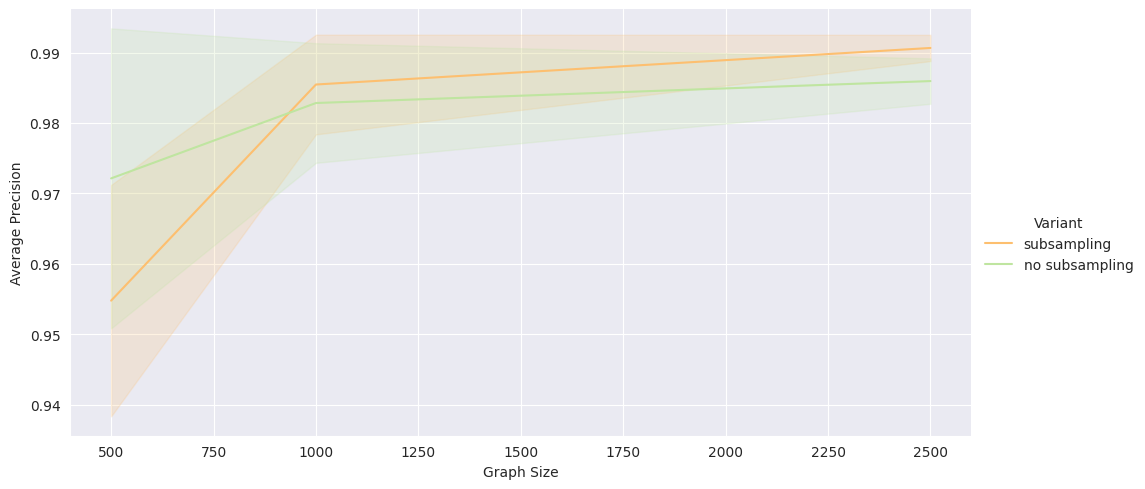

In [37]:
# score
g = sns.relplot(
    data=df_result, kind="line",
    hue="type",
    x="graph_size",
    y="ap",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)
g.set_axis_labels("Graph Size", "Average Precision")
g._legend.set_title("Variant")
plt.savefig('ap.pdf')

<AxesSubplot: xlabel='graph_size', ylabel='run_time'>

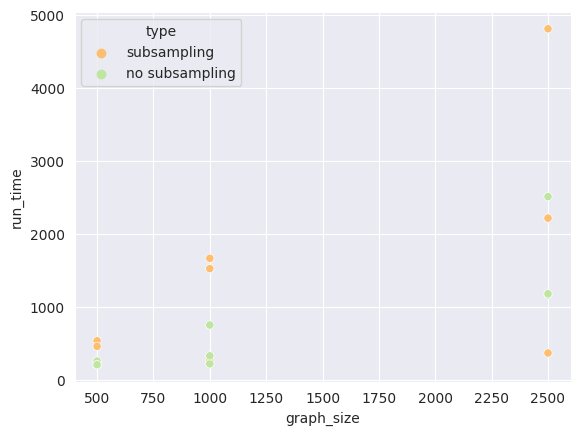

In [41]:
sns.scatterplot(
    data=df_result,
    hue="type",
    x="graph_size",
    y="run_time",
    palette="Spectral"
)

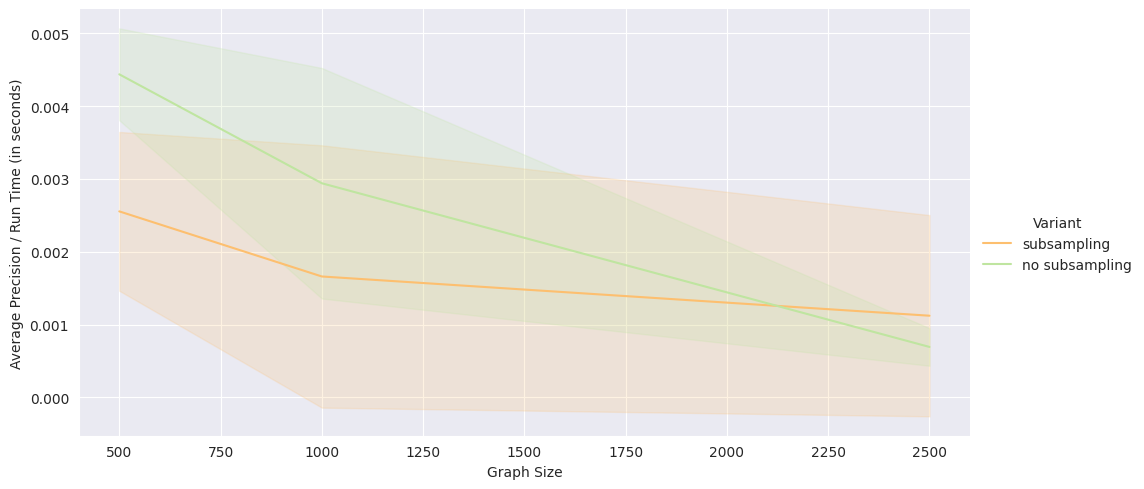

In [50]:
# score per time
df_result["rel_ap"] = df_result['ap'] / df_result['run_time']
g = sns.relplot(
    data=df_result, kind="line",
    hue="type",
    x="graph_size",
    y="rel_ap",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)
g.set_axis_labels("Graph Size", "Average Precision / Run Time (in seconds)")
g._legend.set_title("Variant")
plt.savefig('rel_ap.pdf')

# Load folder

In [15]:
path = "./results/graph-size/no_sub"
all_files = glob.glob(os.path.join(path, "*.csv.zip"))
df_with = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df_with["type"] = "subsampling"

In [16]:
path = "./results/graph-size/with_sub"
all_files = glob.glob(os.path.join(path, "*.csv.zip"))
df_without = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df_without["type"] = "no subsampling"

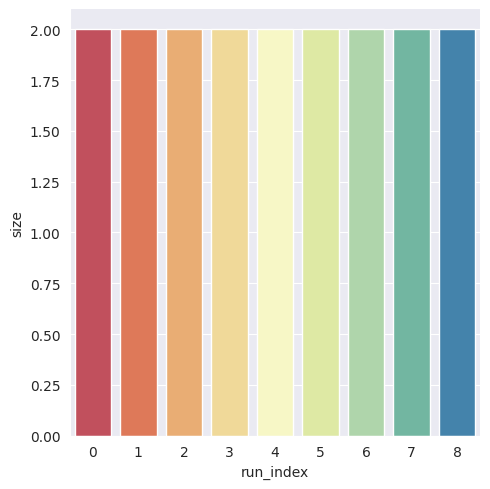

In [17]:
df = pd.concat((df_with, df_without), ignore_index=True)
#df_result.to_csv(os.path.join(path, "complete.csv.zip"), index=False, compression=dict(method='zip', archive_name=f"complete.csv"))

df_result_count = df.groupby(["run_index"], as_index=False)["run_index"].size()
sns.catplot(
    data=df_result_count,
    x="run_index",
    y="size",
    palette="Spectral",
    kind="bar"
)

In [18]:
df_result = df

In [44]:
df_result.to_csv(os.path.join(path, "both.csv.zip"), index=False, compression=dict(method='zip', archive_name=f"both.csv"))